# Probando con nuevas imagenes

Cargamos los clasificadores:

In [1]:
import pickle

path = '..//rsc//obj//'

# Todas las rutas
svm_path = path + 'svm_clf.sav'
svm2_path = path + 'svm2_clf.sav'
gtb_path = path + 'gtb_clf.sav'
rf_path = path + 'rf_clf.sav'

# Serizalización
svm_clf = pickle.load(open(svm_path, 'rb'))
svm2_clf = pickle.load(open(svm2_path, 'rb'))
gtb_clf = pickle.load(open(gtb_path, 'rb'))
rf_clf = pickle.load(open(rf_path, 'rb'))

classifiers = [svm_clf, svm2_clf
               , gtb_clf, rf_clf]

# Funciones auxiliares

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [3]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [4]:
# import the necessary packages
import numpy as np

# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

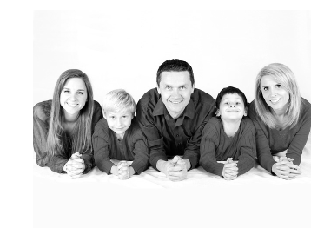

In [5]:
#Imports
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity
from skimage import io, feature
from skimage.transform import rescale

img3 = io.imread("..\\rsc\\img\\family.jpg")

# Convertimos imagen a escala de grises
from skimage.color import rgb2gray
img3 = rgb2gray(img3)
img3 = rescale(img3, 0.5)

# Mostramos la imagen resultante
plt.imshow(img3, cmap='gray')
plt.axis('off');


In [6]:
indices, patches = zip(*sliding_window(img3))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(12255, 1215)

In [7]:
labels = []
for i in range(len(classifiers)):
    labels.append(classifiers[i].predict(patches_hog))
    print(labels[i].sum())

107.0
24.0
207.0
70.0


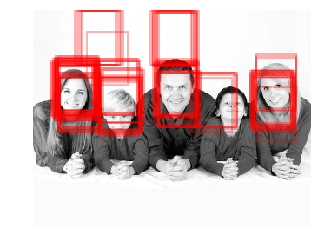

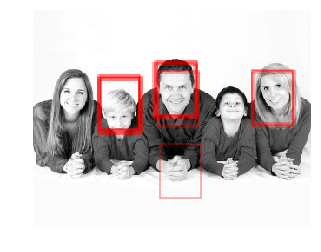

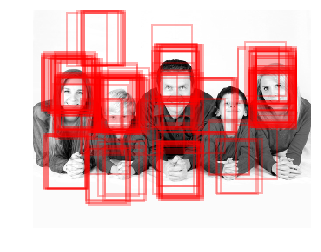

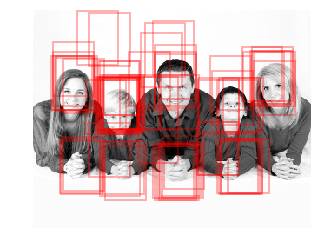

In [8]:
for i in range(len(classifiers)):
    fig, ax = plt.subplots()
    ax.imshow(img3, cmap='gray')
    ax.axis('off')

    Ni, Nj = positive_patches[0].shape
    indices = np.array(indices)
    
    boxes3 = list()
    for i, j in indices[labels[i] == 1]:
        boxes3.append((j,i,j+Nj,i+Ni))
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                                   alpha=0.3, lw=2, facecolor='none'))
    boxes3 = np.array(boxes3)